<a href="https://colab.research.google.com/github/DGkurnia/sentiment/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama: Derfansyah Guswiranata Kurnia
* Identitas Dicoding : dgkurnia
* email dicoding : weerakurnia@gmail.com
* Alamat: Jalan Malaka Hijau No 39 Perumahan Malaka Country Estate Jakarta Timur

#Pembaruan

In [1]:
#request dan pandas
!pip install requests pandas

In [2]:
#instalasi sastarawi
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00


In [3]:
#instalasi wordcloud
!pip install wordcloud

In [4]:
#instalasi XGBOOSTER
!pip install xgboost

In [5]:
#instalasi backoff
!pip install backoff aiohttp

In [6]:
#instalasi S-BERT
!pip install sentence-transformers

# Impor Perpustakaan

In [7]:
#untuk akses ke google drive (bila diperlukan)
from google.colab import drive
drive.mount('/content/drive')
#impor file lokal
from google.colab import files

Mounted at /content/drive


In [8]:
#instalasi perpustakaan
import requests
import json
#Bagian Pandas
import pandas as pd
pd.options.mode.chained_assignment = None #pengaturan peringatan 'rantai'
import csv
import string
#ke manajemen

In [9]:
#manajemen data dasar
import numpy as np
seed = 0 #reprodubilitas
np.random.seed(seed)
#ke plt

In [10]:
#Bagian plt
import matplotlib.pyplot as plt
import datetime as dt #jika ada tanggal
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d
#waktu
import time
#ke sastawi, NLTK, dan wordcloud

In [11]:
#Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #bagian 'stemmer factory'
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [12]:
#sastrawi dan NITK [NITK]
import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
from nltk.corpus import stopwords  # Mengimpor modul stopwords dari pustaka NLTK.
from nltk.tokenize import word_tokenize  # Mengimpor fungsi word_tokenize dari modul tokenize dalam pustaka NLTK.

#impor wordcloud
from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
#ke sastrawi

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
#multiprocessing
import warnings #peringatan
import multiprocessing as mp #untuk multiprocessing
from multiprocessing import Pool
import joblib #Bagian Joblib
#berat data
from sklearn.utils.class_weight import compute_sample_weight as csw #inspeksi berat dulu

### Impor Teknik

In [100]:
#pemisahan data dengan 'train test split' dan bernouli
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
#pelabelan
from sklearn.preprocessing import LabelEncoder #untuk SVM
from sklearn.preprocessing import MultiLabelBinarizer as mlbin #untuk regresi logistik

In [164]:
#Teknik untuk inspeksi: perpustakaan untuk klasifikasi
from sklearn.ensemble import RandomForestClassifier as rfclasifi #teknik 'randomfprest'
from sklearn.tree import DecisionTreeClassifier #teknik 'keputusan'
from sklearn.svm import SVC #teknik SVC
from sklearn.naive_bayes import BernoulliNB

In [17]:
#teknik tmodel gensim
from sklearn.model_selection import learning_curve as lencur #Kurva pemberlajaran

In [18]:
#Bagian re IO bentuk string
import re
from io import StringIO
#modifikais dengan ADASYN
from imblearn.over_sampling import ADASYN
#Transformasi kata
from gensim.models import FastText

In [19]:
#metrik penilaian (akurasi, lenyap/loss, nilai f1, nilai recall)
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
#metrik
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix as cmatrix, ConfusionMatrixDisplay as cmatdisp, classification_report as clsfrep
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
#laporan klasifikasi
from sklearn.datasets import make_classification

In [23]:
#impor seaborn dkk
import seaborn as sns
#vekrtorisasi
from sklearn.feature_extraction.text import TfidfVectorizer #Tfid
from sklearn.feature_extraction.text import CountVectorizer #Count
#word 2 doc
from gensim.models import Word2Vec

In [21]:
#Teknik SVM dengan XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

#Persiapan Ekstraksi situs

##Pendaftaran situs

In [24]:
#deklarasi 'URL target' dan asal URL
turldoma = 'https://gql.tokopedia.com/graphql/productReviewList'
asal = 'https://www.tokopedia.com' #semua dari Tokopedia
#ke pendaftaran URL

In [25]:
"""
#Daftar 'URL referensi' dan 'cookie' di Tokopedia
#daftar URL referensi (dinaikan jadi 26)
"""
uploaded = files.upload()
nmfil0 = "situs.txt"
urllist = []
#ke pebukaan file untuk situs
#pembukaan file
with open(nmfil0, 'r') as f:
    urllist = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
#print(urllist) #cek bentuk dahulu
print(len(urllist))

Saving situs.txt to situs.txt
29


In [26]:
#pendaftaran cookie (dari atas ke bawah: a,b,c,d,e,f,g,h,i,j,k,l,m,n)
uploaded = files.upload()
nmfil0b = "cookie.txt"
cooklist = []
#pembukaan file
with open(nmfil0b, 'r') as f:
    cooklist = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
print(len(cooklist))  # bentuk Jadi

Saving cookie.txt to cookie.txt
29


In [27]:
#persiapan 'identitas produk'
idlist =  [  "2390937942","1631510531","1631524053","2004687552","7576252307", "1624334615", "7576433902",  "1624293521", "1624323568" ,"1624205892", "1850455319","1822516139",
           "1624428906", "7876362065", "1624265285", "1764737976", "1624357196","1624417776","1624322866",
           "7877584454", "1624392272","1624297447","7878113218", "2080268224", "2080277506", "2080234122","7576024423", "1717846972","2263578017" ] #semua sampel ini dari produk Erigo
print(len(idlist))
#ke fragmentasi

29


urutan identitas produk dari kiri ke kanan : [a , b , c , d , e, f ,g ,h, i , j ,k , l, m, n , o , p, q, r, s, t, u, v]

In [28]:
#fragmentasi data untuk kemudahan
[urla, urlb, urlc, urld, urle, urlf, urlg, urlh, urli, urlj, urlk, urll, urlm, urln, urlo, urlp, urlq, urlr, urls, urlt, urlu, urlv, urlw, urlx, urly, urlz, urlza, urlzb, urlzc] = urllist #daftar URL referensi
"""
#[cookiea, cookieb, cookiec, cookied, cookiee, cookief, cookieg, cookieh, cookiei, cookiej, cookiek, cookiel, cookiem, cookiem, cookien, cookieo, cookiep, cookieq, cookier, cookies, cookiet, cookieu, cookiev, cookiew, cookiex] = cooklist #daftar cookie
"""
[ida, idb, idc, idd, ide, idf, idg, idh, idi, idj, idk, idl, idm, idn,ido, idp, idq, idr, ids, idt, idu, idv, idw, idx, idy, idz, idza, idzb, idzc] = idlist #daftar ID produk
#ke persiapan target dan kepala

# Proses Iterasi untuk data

## Persiapan

### Pembentukan kepala dan **'bentuk kueri'**

In [29]:
#Persiapan kepala dan kueri yang distandardisasi
def stdheader(url, idpr): #idpr adalah identitas produk
  halaman_awal = 1 #di kueri
  kplstd = {'accept': '*/*',
   'accept-language': 'en-US,en;q=0.9',
   'content-type': 'application/json',
   'dnt': '1' ,
   'origin': asal,
   'priority': 'u=1, i',
   'referer': url,
   'sec-ch-ua': '"Not A(Brand";v="8", "Chromium";v="132", "Google Chrome";v="132"',
   'sec-ch-ua-mobile': '?0',
   'sec-ch-ua-platform': '"Windows"',
   'sec-fetch-dest': 'empty',
   'sec-fetch-mode': 'cors',
   'sec-fetch-site': 'same-site',
   'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36',
   'x-price-center': 'true',
   'x-source': 'tokopedia-lite',
   'x-tkpd-lite-service': 'zeus',
   'x-version': '1c2c0dd'}
  return kplstd

In [30]:
#variasi kepala untuk iterasi [dari indeks 0 ke lima dengan arah kiri ke kanan]
kplstdlist = [stdheader(urla, ida), stdheader(urlb, idb), stdheader(urlc, idc), stdheader(urld, idd), stdheader(urle, ide),stdheader(urlf, idf),
              stdheader(urlg, idg), stdheader(urlh, idh), stdheader(urli, idi), stdheader(urlj, idj),stdheader(urlk, idk), stdheader(urll, idl),
              stdheader(urlm, idm), stdheader(urln, idn), stdheader(urlo,ido),stdheader(urlp,idp), stdheader(urlq,idq), stdheader(urlr,idr),
              stdheader(urls,ids), stdheader(urlt,idt), stdheader(urlu,idu),stdheader(urlv,idv), stdheader(urlw,idw), stdheader(urlx,idx),
              stdheader(urly,idy), stdheader(urlz,idz), stdheader(urlza,idza), stdheader(urlzb,idzb), stdheader(urlzc,idzc)]
#ke persiapan bentuk melalui iterasi

### Iterasi utama untuk menghasilkan data

In [31]:
# Proses iterasi produk
def datagenerator(url, idpr):
    # Pemanggilan fungsi pertama (stdheader)
    header = stdheader(url, idpr)
    # Persiapan bentuk untuk iterasi
    daftar_teks = []
    daftar_nilai = []
    daftar_label = []

    # Batas halaman untuk ulasan
    awal = 1  # dari halaman 1
    akhir = 50  # batas ulasan paling tinggi

    # Iterasi
    while awal <= akhir:
        # Pemformatan kueri
        fquery = f'[{{"operationName":"productReviewList","variables":{{"productID":"{idpr}","page":{awal},"limit":10,"sortBy":"informative_score desc","filterBy":""}},"query":"query productReviewList($productID: String\u0021, $page: Int\u0021, $limit: Int\u0021, $sortBy: String, $filterBy: String) {{\\n  productrevGetProductReviewList(productID: $productID, page: $page, limit: $limit, sortBy: $sortBy, filterBy: $filterBy) {{\\n    productID\\n    list {{\\n      id: feedbackID\\n      variantName\\n      message\\n      productRating\\n      reviewCreateTime\\n      reviewCreateTimestamp\\n      isReportable\\n      isAnonymous\\n      imageAttachments {{\\n        attachmentID\\n        imageThumbnailUrl\\n        imageUrl\\n        __typename\\n      }}\\n      videoAttachments {{\\n        attachmentID\\n        videoUrl\\n        __typename\\n      }}\\n      reviewResponse {{\\n        message\\n        createTime\\n        __typename\\n      }}\\n      user {{\\n        userID\\n        fullName\\n        image\\n        url\\n        __typename\\n      }}\\n      likeDislike {{\\n        totalLike\\n        likeStatus\\n        __typename\\n      }}\\n      stats {{\\n        key\\n        formatted\\n        count\\n        __typename\\n      }}\\n      badRatingReasonFmt\\n      __typename\\n    }}\\n    shop {{\\n      shopID\\n      name\\n      url\\n      image\\n      __typename\\n    }}\\n    hasNext\\n    totalReviews\\n    __typename\\n  }}\\n}}\\n"}}]'

        # Make request
        response = requests.post(turldoma, headers=header, data=fquery)

        # Check for HTTP errors
        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code}")
            break

        try:
            daftar_ulasan = response.json()[0]['data']['productrevGetProductReviewList']['list']
            if not daftar_ulasan:
                break  # Exit loop if no reviews are returned

            for review in daftar_ulasan:
              daftar_teks.append(review['message'])
              daftar_nilai.append(review['productRating'])
              if review['productRating'] == 0:
                  daftar_label.append('total disappointment') #hal yang mengecewakan sekali
              elif review['productRating'] == 1:
                  daftar_label.append('so inferior') #hal sangat inferior
              elif review['productRating'] == 2:
                  daftar_label.append('very low') #sangat rendah
              elif review['productRating'] == 3:
                  daftar_label.append('average') #rata-rata
              elif review['productRating'] == 4:
                  daftar_label.append('good') #sangat bagus
              elif review['productRating'] == 5:
                  daftar_label.append('excelent') #sempurna
              else:
                  daftar_label.append('No score') #tak mau diulas
            awal += 1


        except (KeyError, IndexError) as e:
            print(f"Error parsing JSON response: {e}")
            break

    return daftar_teks, daftar_nilai, daftar_label
#ke eksekusi

#### Eksekusi iterasi

In [32]:
#Proses pembentukan daftar dari enam produk untuk disatukan (Bagian 1)
teks1, nilai1, label1 = datagenerator(urla, ida) #ProdukA
teks2, nilai2, label2 = datagenerator(urlb, idb) #ProdukB
teks3, nilai3, label3 = datagenerator(urlc, idc) #ProdukC
teks4, nilai4, label4 = datagenerator(urld, idd) #Produk D
#ke bagian 2

In [33]:
#Bagian 2
teks5, nilai5, label5 = datagenerator(urle, ide) #Produk E
teks6, nilai6, label6 = datagenerator(urlf,idf) #produk F
teks7, nilai7, label7 = datagenerator(urlg,idg) #produk G
teks8, nilai8, label8 = datagenerator(urlh,idh) #produk H
#ke bagian 3

In [34]:
#Bagian 3
teks9, nilai9, label9 = datagenerator(urli,idi) #produk I
teks10, nilai10, label10 = datagenerator(urlj,idj) #produk J
teks11, nilai11, label11 = datagenerator(urlk,idk) #produk K
teks12, nilai12, label12 = datagenerator(urll,idl) #produk L
#ke bagian 4

In [35]:
#Bagian 4
teks13, nilai13, label13 = datagenerator(urlm,idm) #produk M
teks14, nilai14, label14 = datagenerator(urln,idn) #produk N
teks15, nilai15, label15 = datagenerator(urlo,ido) #produk 0
teks16, nilai16, label16 = datagenerator(urlp,idp) #produk P

In [36]:
#Bagian 5
teks17, nilai17, label17 = datagenerator(urlq,idq) #produk Q
teks18, nilai18, label18 = datagenerator(urlr,idr) #produk R
teks19, nilai19, label19 = datagenerator(urls,ids) #produk S
teks20, nilai20, label20 = datagenerator(urlt,idt) #produk T

In [37]:
#Bagian 6
teks21, nilai21, label21 = datagenerator(urlu,idu) #produk U
teks22, nilai22, label22 = datagenerator(urlv,idv) #produk V
teks23, nilai23, label23 = datagenerator(urlw,idw) #produk X
teks24, nilai24, label24 = datagenerator(urlx,idx) #produk Y

In [38]:
#Bagian 7
teks25, nilai25, label25 = datagenerator(urly,idy) #produk Y
teks26, nilai26, label26 = datagenerator(urlz,idz) #produk Z
teks27, nilai27, label27 = datagenerator(urlza,idza) #produk ZA
teks28, nilai28, label28 = datagenerator(urlzb,idzb) #produk ZB
#ke penyatuan

In [39]:
#Bagian 8
teks29, nilai29, label29 = datagenerator(urlzc,idzc) #produk ZC

### Penyatuan ke satu data

In [40]:
#Penyatuan tahap 1 (data teks baju dan celana)
tekskao = teks1 + teks2
teksba =  teks3 + teks4 + teks5 + teks6 + teks7 + teks8 + teks9 #dari baju
tekscel = teks10 + teks11 + teks12 + teks13 + teks14 + teks15 + teks16 + teks17+ teks18+ teks19 + teks20 + teks21  #dari celana panjang
tekscelp = teks22 + teks23 + teks24 + teks25 + teks26 #dari celana pendek
tekscejeg = teks27 + teks28 + teks29 #dari celana jogger
#bagian nilai
nilkao = nilai1 + nilai2
nilba =  nilai3 + nilai4 + nilai5 + nilai6 + nilai7 + nilai8 + nilai9 #Baju
nilcel = nilai10 + nilai11 + nilai12 + nilai13 + nilai14 + nilai15 + nilai16 + nilai17 + nilai18 + nilai19 + nilai20 + nilai21  #Celana panjang
nilcelp = nilai22 + nilai23 + nilai24 + nilai25 + nilai26  #Celana pendek
nilcejeg = nilai27 + nilai28 + nilai29 #aspek nilai dari celana jogger
#Bagian label
labekao = label1 + label2
labeba = label3 + label4 + label5 + label6 + label7 + label8 + label9 #label baju
labecel = label10 + label11 + label12 + label13 + label14 + label15 + label16 + label17 + label18 + label19 + label20 + label21 #label celana panjang
labecelp = label22 + label23 + label24 + label25 + label26 + label27 #label celana pendek
labcejeg = label27 + label28 + label29 #label celana jogger

In [41]:
#deklarasi total ulasan
sampteks = tekskao + teksba + tekscel + tekscelp + tekscejeg #bagian teks
sampnilai = nilkao + nilba + nilcel + nilcelp + nilcejeg #bagian nilai
samplabel = labekao + labeba + labecel + labecelp + labcejeg #bagian label
#ke konversi ke df

semua ulasan ini berasal dari enam produk berasal dari Erigo

In [43]:
# Pengisian data
max_len = max(len(sampteks), len(sampnilai), len(samplabel))

# Pengisian ualng data
sampteks += [None] * (max_len - len(sampteks))
sampnilai += [None] * (max_len - len(sampnilai))
samplabel += [None] * (max_len - len(samplabel))

# Buat data
dfori = pd.DataFrame({'Pesan': sampteks, 'Nilai': sampnilai, 'Label': samplabel}, copy=True)
dfkopi = dfori.copy()

# Cek panjang data
lendfkop = len(dfkopi)
print(lendfkop)

12870


#### Inspeksi hasil data dari kesalahan

In [44]:
#cek sampel data
kepdfkopi = dfkopi.head(7)
kepdfkopi

,Pesan,Nilai,Label
0,mantapo bangett baguss bahannya lembut nyaman ...,5.0,excelent
1,"pesanan selamat sampai tujuan, keren t-shirt n...",5.0,excelent
2,Kualitas produk bagus. Jahitannya rapi. Nyaman...,5.0,excelent
3,"Bagus banget. Ukuran pas, bahan tebal tapi ade...",5.0,excelent
4,"pengiriman cepet,seller gercep alias gerak cep...",5.0,excelent
5,Sesuai pesanan meskipun pengirimannya lama. Ba...,5.0,excelent
6,"Response Seller Mantul, Packing dan Pengiriman...",5.0,excelent


In [45]:
#cek kolom
dfkopinfo = dfkopi.info()
print(dfkopinfo)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12870 entries, 0 to 12869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pesan   12370 non-null  object 
 1   Nilai   12370 non-null  float64
 2   Label   12870 non-null  object 
dtypes: float64(1), object(2)
memory usage: 301.8+ KB
None


#### Pembersihan data (bebas dari data duplikat dan kosong)

In [46]:
#Data Kosong
totkos = dfkopi.isnull().sum() #Kosong
totkos

,0
Pesan,500
Nilai,500
Label,0


In [47]:
#inspeksi data hilang
tothil = dfkopi.isna().sum() #Hilang
print(tothil)

Pesan    500
Nilai    500
Label      0
dtype: int64


In [48]:
#inspeksi data duplikat
dfkopi.duplicated().sum()

2832

### Eksekusi pembersihan

#### Pembersihan data kosong

In [49]:
#pengisian data kosong di 'Pesan'
tabpes = dfkopi['Pesan'].copy()
tabpes.fillna('kosong', inplace=True)
dfkopi['Pesan'] = tabpes

In [50]:
#inspeksi tahap 1
dfkopi.isna().sum()

,0
Pesan,0
Nilai,500
Label,0


In [51]:
#Tahap 2: pengisian data kosong di kolom nilai
tabnil = dfkopi['Nilai'].copy()
tabnil.fillna(0, inplace=True) #tak ada tanggapan
dfkopi['Nilai'] = tabnil
#inspeksi tahap 2
dfkopi.isna().sum()

,0
Pesan,0
Nilai,0
Label,0


#### Penghapusan data duplikat

In [52]:
#Pembersihan data duplikat
dfkopi.drop_duplicates(inplace=True)
dfkopitung = dfkopi.copy()
kep2 = dfkopitung.head(7) #pasca pembersihan
print(kep2)

                                               Pesan  Nilai     Label
0  mantapo bangett baguss bahannya lembut nyaman ...    5.0  excelent
1  pesanan selamat sampai tujuan, keren t-shirt n...    5.0  excelent
2  Kualitas produk bagus. Jahitannya rapi. Nyaman...    5.0  excelent
3  Bagus banget. Ukuran pas, bahan tebal tapi ade...    5.0  excelent
4  pengiriman cepet,seller gercep alias gerak cep...    5.0  excelent
5  Sesuai pesanan meskipun pengirimannya lama. Ba...    5.0  excelent
6  Response Seller Mantul, Packing dan Pengiriman...    5.0  excelent


In [53]:
#cek panjang
lendfkop2 = len(dfkopitung)
print(lendfkop2)

10038


#### Inspeksi kolom dan baris di hasil tunggal

In [54]:
#inspeksi
bntkdf = dfkopitung.shape
bntkdf

(10038, 3)

# Persiapan tahapan ulasan

## Penataan ulang kata-kata

### Kata Gaul

In [55]:
#Deklarasi kata-kata gaul
uploaded = files.upload()
nmfila = "kata.txt"
kata_gaul = []
#penulisan kata-kata gaul
with open(nmfila, 'r') as f:
    kata_gaul = [line.strip() for line in f.readlines()]  # Pembacaan garis
#cetak bentuk akhir
#print(kata_gaul)  # bentuk Jadi

Saving kata.txt to kata.txt


### Kamus Gaul

In [56]:
#Deklarasi kamus gaul
uploaded = files.upload()
nmfilb = "kamus.txt"
kamus_gaul = {}
#Penulisan kamus
with open(nmfilb, 'r') as f:
  for line in f:
    parts = line.strip().split(':', 1)  # Pembagian batas
    if len(parts) == 2:  # Hanya dua komponen
        kunci, nilai = parts
        kamus_gaul[kunci] = nilai
#cetak penataan ulang
#print(kamus_gaul)

Saving kamus.txt to kamus.txt


## Tahapan evaluasi kata-kata ke nilai

### Tahap Awal

In [57]:
#Kumpulan fungsi tahap 1 [Pembersihan dan penyeragaman]
def textcleaner (text): #Tahap 1
   text = re.sub(r'@[A-Za-z0-9]+', '', text) #penghilangan tanda at
   text = re.sub(r'#[A-Za-z0-9]+', '', text) #penghilangan tanda pagar
   text = re.sub(r'RT[\s]', '', text) #Bagian RE
   text = re.sub(r"http\S+", '', text) #Bagian penetralan HTTP
   text = re.sub(r'[0-9]+', '', text)
   text = re.sub(r'[^\w\s]', '', text)

   text = text.replace('\n', ' ')
   text = text.translate(str.maketrans('', '', string.punctuation))
   text = text.strip(' ')
   return text
#konversi ke huruf kecil dan 'tokenisasi'
def casefoldingText(text): # Konversi ke kata kecil
    text = text.lower()
    return text

def tokenizingText(text): # Tokenisasi
    text = word_tokenize(text)
    return text
#ke penyaringan

In [58]:
#penyaringan dan 'stemming' penyaringan
def textfilter(text):
    listStopwordsid = set(stopwords.words('indonesian'))
    listStopwordsen = set(stopwords.words('english'))
    listStopwordsid.update(listStopwordsen) #untuk ingris
    listStopwordsid.update(kata_gaul)
    filtrat = []
    for txt in text:
        if txt not in listStopwordsid:
            filtrat.append(txt)
    text = filtrat
    return text
#tahap steming
def textstemmer(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()


    words = text.split()


    stemmed_words = [stemmer.stem(word) for word in words]


    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def sentencerer(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [59]:
#manajemen kata-kata gaul
def slangfixer(text): #tolong pakai etika ya
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in kamus_gaul:
            fixed_words.append(kamus_gaul[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

### Persiapan filtrasi dari kolom pesan

In [60]:
#pengambilan kolom pesan
isipes = dfkopitung['Pesan'].copy() #cek pesan
nomor = dfkopitung['Nilai'].copy() #cek nilai
kategori = dfkopitung['Label'].copy() #cek Label

In [61]:
#Eksekusi masing-masing fungsi
dfkopitungk = dfkopitung.copy() #Jangan pakai data asli
#pelaksanaan fungsi [pembersihan teks]
dfkopitungk['bersih'] = isipes.apply(textcleaner)
#pemerataan
dfkopitungk['kecil'] = dfkopitungk['bersih'].apply(casefoldingText)
#pemformalan kata
dfkopitungk['sopan'] = dfkopitungk['kecil'].apply(slangfixer) #pakai etika
#ke tahapan selanjutnya

In [62]:
#tahapan selanjutmya
#pengambilan sampel ke 'tokenisasi'
dfkopitungk['token'] = dfkopitungk['sopan'].apply(tokenizingText) #tokenisasi
#penyaringan
dfkopitungk['stopword'] = dfkopitungk['token'].apply(textfilter)
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
dfkopitungk['final'] = dfkopitungk['token'].apply(sentencerer)

In [63]:
#cek bentuk akhir
kplmk3 = dfkopitungk.head(7)
kplmk3

,Pesan,Nilai,Label,bersih,kecil,sopan,token,stopword,final
0,mantapo bangett baguss bahannya lembut nyaman ...,5.0,excelent,mantapo bangett baguss bahannya lembut nyaman ...,mantapo bangett baguss bahannya lembut nyaman ...,mantapo bangett baguss bahannya lembut nyaman ...,"[mantapo, bangett, baguss, bahannya, lembut, n...","[mantapo, bangett, baguss, bahannya, dipake, b...",mantapo bangett baguss bahannya lembut nyaman ...
1,"pesanan selamat sampai tujuan, keren t-shirt n...",5.0,excelent,pesanan selamat sampai tujuan keren tshirt nya...,pesanan selamat sampai tujuan keren tshirt nya...,pesanan selamat sampai tujuan keren tshirt nya...,"[pesanan, selamat, sampai, tujuan, keren, tshi...","[pesanan, selamat, tujuan, tshirt, cuttingan, ...",pesanan selamat sampai tujuan keren tshirt nya...
2,Kualitas produk bagus. Jahitannya rapi. Nyaman...,5.0,excelent,Kualitas produk bagus Jahitannya rapi Nyaman d...,kualitas produk bagus jahitannya rapi nyaman d...,kualitas produk bagus jahitannya rapi nyaman d...,"[kualitas, produk, bagus, jahitannya, rapi, ny...","[jahitannya, dipakai, warnanya, modelnya, baha...",kualitas produk bagus jahitannya rapi nyaman d...
3,"Bagus banget. Ukuran pas, bahan tebal tapi ade...",5.0,excelent,Bagus banget Ukuran pas bahan tebal tapi adem ...,bagus banget ukuran pas bahan tebal tapi adem ...,bagus banget ukuran pas bahan tebal tapi adem ...,"[bagus, banget, ukuran, pas, bahan, tebal, tap...","[ukuran, cutting, jahitan, rapiiih]",bagus banget ukuran pas bahan tebal tapi adem ...
4,"pengiriman cepet,seller gercep alias gerak cep...",5.0,excelent,pengiriman cepetseller gercep alias gerak cepa...,pengiriman cepetseller gercep alias gerak cepa...,pengiriman cepetseller gercep alias gerak cepa...,"[pengiriman, cepetseller, gercep, alias, gerak...","[pengiriman, cepetseller, gercep, cepatselalu,...",pengiriman cepetseller gercep alias gerak cepa...
5,Sesuai pesanan meskipun pengirimannya lama. Ba...,5.0,excelent,Sesuai pesanan meskipun pengirimannya lama Bah...,sesuai pesanan meskipun pengirimannya lama bah...,sesuai pesanan meskipun pengirimannya lama bah...,"[sesuai, pesanan, meskipun, pengirimannya, lam...","[pesanan, pengirimannya, bahannya, thank, erigo]",sesuai pesanan meskipun pengirimannya lama bah...
6,"Response Seller Mantul, Packing dan Pengiriman...",5.0,excelent,Response Seller Mantul Packing dan Pengiriman ...,response seller mantul packing dan pengiriman ...,response seller mantul packing dan pengiriman ...,"[response, seller, mantul, packing, dan, pengi...","[response, seller, mantul, packing, pengiriman...",response seller mantul packing dan pengiriman ...


#Tahap eksekusi

## Tahap 'penerapan lexicon'

#### Deklarasi Lexicon

In [64]:
#Tahap awal fungsi lexicon (positif kiri negatif kanan)
[urlexp, urlexz, urlexn ]= ['https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv', 'https://raw.githubusercontent.com/cjhutto/vaderSentiment/master/vaderSentiment/vader_lexicon.txt', 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv']
#ke fungsi inspeksi lexicon

In [65]:
#tambahan
adisi1 = 'https://github.com/fajri91/InSet/blob/master/positive.tsv'
adisi2 = 'https://github.com/fajri91/InSet/blob/master/negative.tsv'

In [66]:
#URL ke emoji
emourl = 'https://raw.githubusercontent.com/today-is-a-good-day/emojis/refs/heads/master/emDict.csv'

#### Pembuatan lexicon

In [67]:
#lexicon positif di situs 1
plexicon = dict()
#pembutan respon
responp = requests.get(urlexp) #malas menulis lagi
if responp.status_code == 200:
    # Saat berhasil
    plreader = csv.reader(StringIO(responp.text), delimiter=',')
    # Jika Koma

    for row in plreader:
        # Mengulangi setiap baris dalam file CSV
        plexicon[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Data Lexicon Positif gagal diulas")

In [68]:
#lexicon di situs 2
zlexicon = dict()

# Fetch neutral lexicon data
responz = requests.get(urlexz)  # Link URL di atas
if responz.status_code == 200:  # variabel
    # Saat berhasil
    zlreader = csv.reader(StringIO(responz.text), delimiter='\t')
    next(zlreader)  # Skip the header row if it exists

    for row in zlreader:
        # Inspeksi batas
        if len(row) >= 2:
            try:
                # Check for empty strings and handle them gracefully
                if row[0].strip() != '':
                  zlexicon[row[0].strip()] = float(row[1].strip())  # Assuming the score is a float
            except ValueError as e:
                # Handle any rows with invalid data, such as scores that can't be converted to float
                print(f"Error: Invalid data in row: {row}. Skipping...")

else:
    print("Data Lexicon Netral gagal diulas")

In [69]:
#lexicon situs 3
nlexicon = dict()
#respon negatif [geez]
responsn = requests.get(urlexn)
if responsn.status_code == 200:
    # Saat berhasil
    negreader = csv.reader(StringIO(responsn.text), delimiter=',')
    #iterasi reader
    for row in negreader:
        # Mengulangi setiap baris dalam file CSV
        nlexicon[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Data Lexicon Negatif gagal diulas")

In [70]:
# Adisi lexicon 1
zlexicon2 = dict()

# Fetch neutral lexicon data
responz2 = requests.get(adisi1)  # Link URL di atas
if responz.status_code == 200:  # Cek kesuksesan
    # If successful, read the content
    zlreader2 = csv.reader(StringIO(responz2.text), delimiter='\t')  # Pakai tab
    next(zlreader2)  # Skip the header row if it exists

    for row in zlreader2:
        # Inspect boundaries
        if len(row) >= 2:
            try:
                # Check for empty strings and handle them gracefully
                if row[0].strip() != '':
                    zlexicon2[row[0].strip()] = float(row[1].strip())  # Assuming the score is a float
            except ValueError as e:
                # Handle any rows with invalid data, such as scores that can't be converted to float
                print(f"Error: Invalid data in row: {row}. Skipping...")
else:
    print("Data Lexicon Netral gagal diulas")

In [71]:
#adisi2
plexicon2 = dict()

# Fetch neutral lexicon data
responp2 = requests.get(adisi2)  # Link URL di atas
if responz.status_code == 200:  # Check if the request was successful
    # If successful, read the content
    plreader2 = csv.reader(StringIO(responp2.text), delimiter='\t')  # Pakai tab
    next(plreader2)  # Skip the header row if it exists

    for row in plreader2:
        # Inspect boundaries
        if len(row) >= 2:
            try:
                # Check for empty strings and handle them gracefully
                if row[0].strip() != '':
                    plexicon2[row[0].strip()] = float(row[1].strip())  # Assuming the score is a float
            except ValueError as e:
                # Handle any rows with invalid data, such as scores that can't be converted to float
                print(f"Error: Invalid data in row: {row}. Skipping...")
else:
    print("Data Lexicon Netral gagal diulas")

##### Lexicon Emoji

In [72]:
#Akses ke Emoji 1
emodf = pd.read_csv(emourl, sep=';')
#cek kepala
kepemodf = emodf.head(7)
print(kepemodf)

         Description Native             Bytes                R-encoding
0     AERIAL TRAMWAY      🚡  \xF0\x9F\x9A\xA1  <ed><a0><bd><ed><ba><a1>
1           AIRPLANE      ✈      \xE2\x9C\x88              <e2><9c><88>
2        ALARM CLOCK      ⏰      \xE2\x8F\xB0              <e2><8f><b0>
3      ALIEN MONSTER      👾  \xF0\x9F\x91\xBE  <ed><a0><bd><ed><b1><be>
4          AMBULANCE      🚑  \xF0\x9F\x9A\x91  <ed><a0><bd><ed><ba><91>
5  AMERICAN FOOTBALL      🏈  \xF0\x9F\x8F\x88  <ed><a0><bc><ed><bf><88>
6             ANCHOR      ⚓      \xE2\x9A\x93              <e2><9a><93>


In [73]:
#inspeksi informasi
emodf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  842 non-null    object
 1   Native       842 non-null    object
 2   Bytes        842 non-null    object
 3   R-encoding   842 non-null    object
dtypes: object(4)
memory usage: 26.4+ KB


In [74]:
#Pengambilan kolom untuk analisis emoji
desk = emodf.iloc[:, [0,1]].copy() #Deskripsi dan 'Native'
#simpan ke csv
#desk.to_csv('daftar.csv', index=True)
#ke impor nilai

In [75]:
#impor penilaian data penilaian
uploaded = files.upload()
dfnilai = pd.read_csv('penilaian.csv')
dfnilai.info()

Saving penilaian.csv to penilaian.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Indeks       842 non-null    int64  
 1   Description  842 non-null    object 
 2   Native       842 non-null    object 
 3   Nilai        828 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.4+ KB


In [76]:
#ambil nilai
nildf = dfnilai['Nilai'].copy()
#ke pengisian

In [77]:
#pengisian
nildf.fillna(0)
print("total data kosong", nildf.isnull().sum())

total data kosong 14


In [78]:
#penggabungan nilai data
dfemoskor = pd.concat([desk, nildf], axis=1, ignore_index=False, copy=True)
#cek kepala
dfemoinfo = dfemoskor.info()
#inspeksi
dfemoinfo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  842 non-null    object 
 1   Native       842 non-null    object 
 2   Nilai        828 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.9+ KB


In [79]:
#isi kolom 'Nilai' dengan 0
medemo = dfemoskor['Nilai'].median()
dfemoskor['Nilai'].fillna(medemo)
#cek kepala
dfemoskor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  842 non-null    object 
 1   Native       842 non-null    object 
 2   Nilai        828 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.9+ KB


#### Penyederhanaan Lexicon

In [80]:
#Kumpulan lexicon positif (dari urlp dan adisi1)
kamposlen = {}
for d in (plexicon, zlexicon2):
    for key, value in d.items():
        if key in kamposlen:
            kamposlen[key].append(value)
        else:
            kamposlen[key] = [value]
#cetak hasil
#print(kamposlen)

In [81]:
#Kumpulan Lexicon negatif (dari urln dan lexicon2)
kamneglen = {}
for d in (nlexicon, plexicon2):
    for key, value in d.items():
        if key in kamneglen:
            kamneglen[key].append(value)
        else:
            kamneglen[key] = [value]
#cetak hasil
#print(kamneglen)

In [82]:
#persiapan evaluasi emoji
penemo = dfemoskor.iloc[:,[1,2]].copy()
kamuemo = dict(penemo) #harus kamus
#cek hasil
print(kamuemo)

{'Native': 0      🚡
1      ✈
2      ⏰
3      👾
4      🚑
      ..
837    🚺
838    😟
839    🎁
840    🔧
841    💛
Name: Native, Length: 842, dtype: object, 'Nilai': 0      0.0
1      0.0
2      0.0
3     -1.0
4      0.0
      ... 
837    0.0
838    0.0
839    0.0
840    0.0
841    2.0
Name: Nilai, Length: 842, dtype: float64}


### Lexicon Indonesia

#### Analisis Lexicon

In [83]:
#daftar kata yang tak boleh ada
uploaded = files.upload()
nmfilf = "filter.txt"
kater = [] #tak bisa ada
#pengisian otomatis untuk pengisian kata yang tak ada
with open(nmfilf, 'r') as f:
      kater = [line.strip() for line in f.readlines()]  # Pembacaan garis
  #cek durasi 'kater'
lenkat = len(kater)
print(lenkat) #jika ada
#ke fungsi utama

Saving filter.txt to filter.txt
32


In [84]:
#penulisan fungsi
def indoesia_sentiment_analysis (text):
  nilai = 0 #awal
    # Inisialisasi skor sentimen awal
#iterasi dari Tiga koleksi
  for word in text:
        # Mengulangi setiap kata dalam teks
        if ((word in kamposlen) and (word not in kater)):
            nilai = nilai + sum(kamposlen[word])
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
  for word in text:
        # Iterasi negatif
        if ((word in kamneglen) and (word not in kater)) :
            nilai = nilai + sum(kamneglen[word])
            # Nilai Netral
  for word in text:
        # Iterasi netral
        if ((word in zlexicon) and (word not in kater)):
            nilai = nilai + zlexicon[word]
            # Nilai Negatif
  #iterasi di kamus emoji
  for word in text:
        # Iterasi emoji
        if (word in kamuemo): #jangan tersinggung
            nilai = nilai + kamuemo[word]
  #inspeksi polaritas
  polaritas=''
    # Inisialisasi variabel polaritas

  if (nilai > 0):
        polaritas = 'positif'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
  elif (nilai < 0):
        polaritas = 'negatif'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
  elif (nilai == 0):
        polaritas = 'netral'
        # Jika skor sentimen sama dengan 0, maka polaritas adalah netral
  else:
        polaritas = 'tidak ada'

  return nilai, polaritas
    # Mengembalikan skor sentimen dan polaritas teks

Eksekusi lexicon Indonesia (bawah)

In [85]:
#Eksekusi leksikon [awal]
stpkol = dfkopitungk['stopword'].copy()
#menampilkan hasil
hasil = stpkol.apply(indoesia_sentiment_analysis)
daftar = list(zip(*hasil))

#pemisahan
dfkopitungk['nilai_polaritas'] = daftar[0]
dfkopitungk['polaritas'] = daftar[1]
#inspeksi nilai sel
selp = dfkopitungk['polaritas'].value_counts() #cek total
print(selp)

polaritas
netral     5308
positif    2831
negatif    1899
Name: count, dtype: int64


#### Visualisasi Lexicon

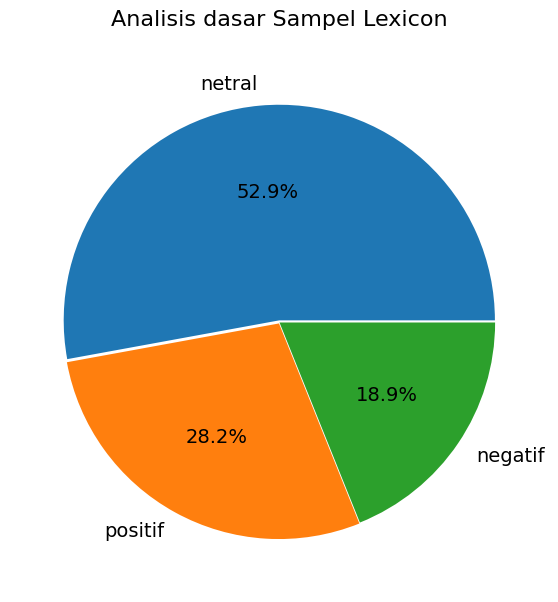

In [86]:
#Inspeksi Pie
fig, ax = plt.subplots(figsize=(7, 7))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in selp]

#pelabelan
labels = list(selp.index)

# Jarak
explode = (0.01, 0.005, 0)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Analisis dasar Sampel Lexicon', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [87]:
#teks sentimen positif: Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi tweet dengan polaritas netral.
ulasanp = dfkopitungk[dfkopitungk['polaritas'] == 'positif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanz'.
cuitanp = ulasanp[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitanp = cuitanp.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitanp = cuitanp.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitanp.index += 1


In [88]:
#sentimen netral: Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi tweet dengan polaritas negatif.
ulasanz = dfkopitungk[dfkopitungk['polaritas'] == 'netral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanp'.
cuitanz = ulasanz[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitanz = cuitanz.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitanz = cuitanz.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitanz.index += 1


In [89]:
#teks sentimen negatif: Pengambilan kolom polaritas
jpolaritas = dfkopitungk['polaritas'].copy()
makskol = 3000
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', makskol)

# Membuat DataFrame baru 'ulasanp' yang hanya berisi cuitan dengan polaritas positif.
ulasann = dfkopitungk[dfkopitungk['polaritas'] == 'negatif']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'ulasanp'.
cuitann = ulasann[['final', 'nilai_polaritas', 'polaritas','stopword']].copy()

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
cuitann = cuitann.sort_values(by='nilai_polaritas', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
cuitann = cuitann.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
cuitann.index += 1


#### Visualisasi kata-kata

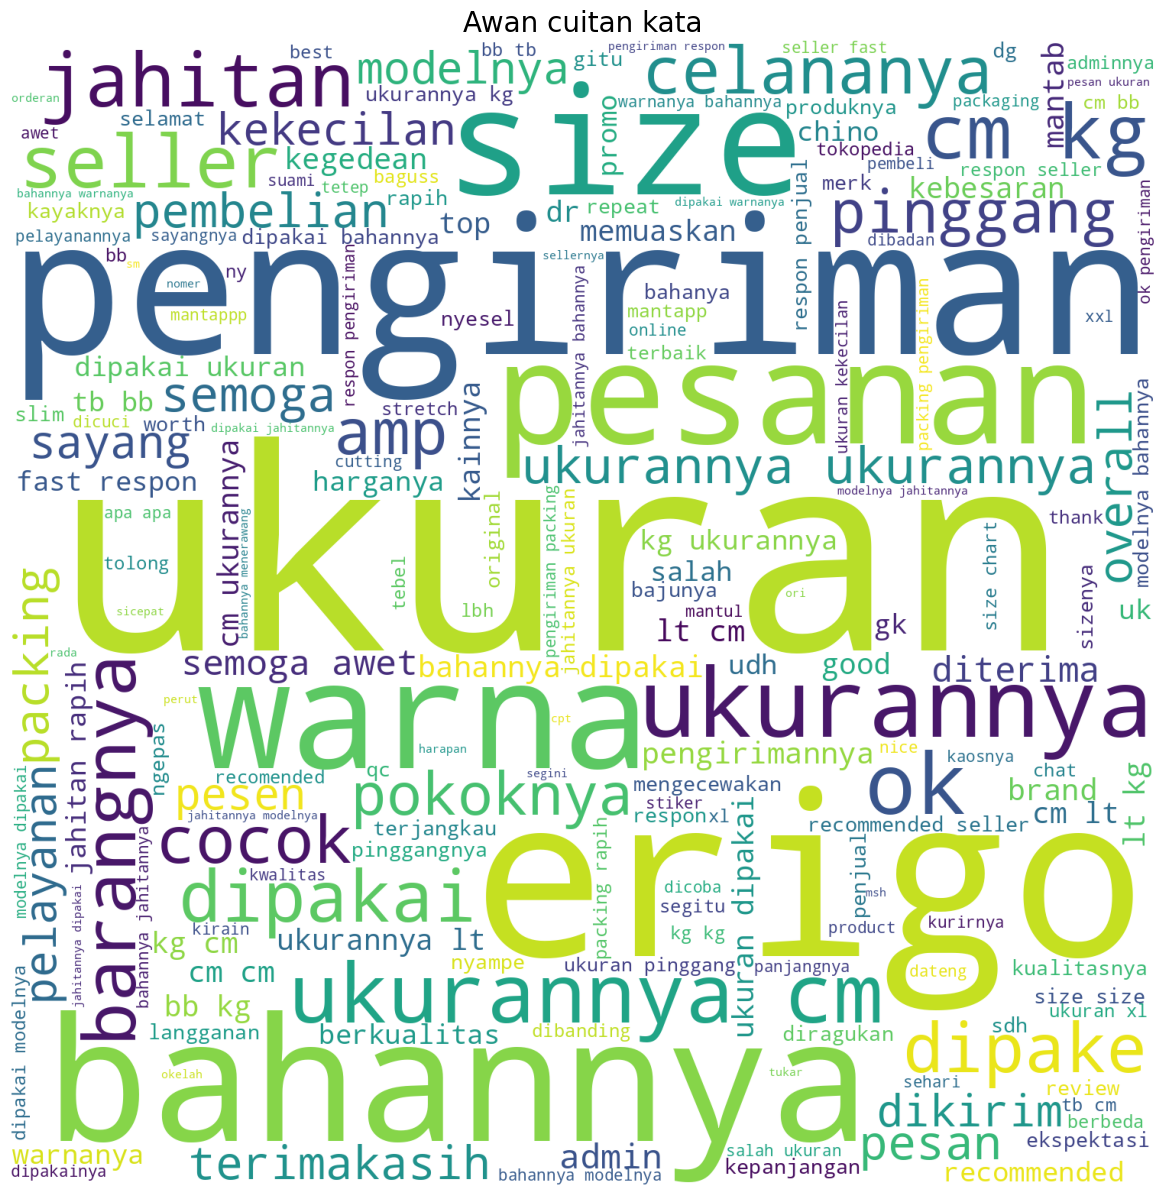

In [90]:
#sentimen di stopword
daftar_kata = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in dfkopitungk['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        daftar_kata += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1500, height=1500, background_color='white', min_font_size=8).generate(daftar_kata)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(12, 12))

# Menetapkan judul untuk word cloud.
ax.set_title('Awan cuitan kata', fontsize=20)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

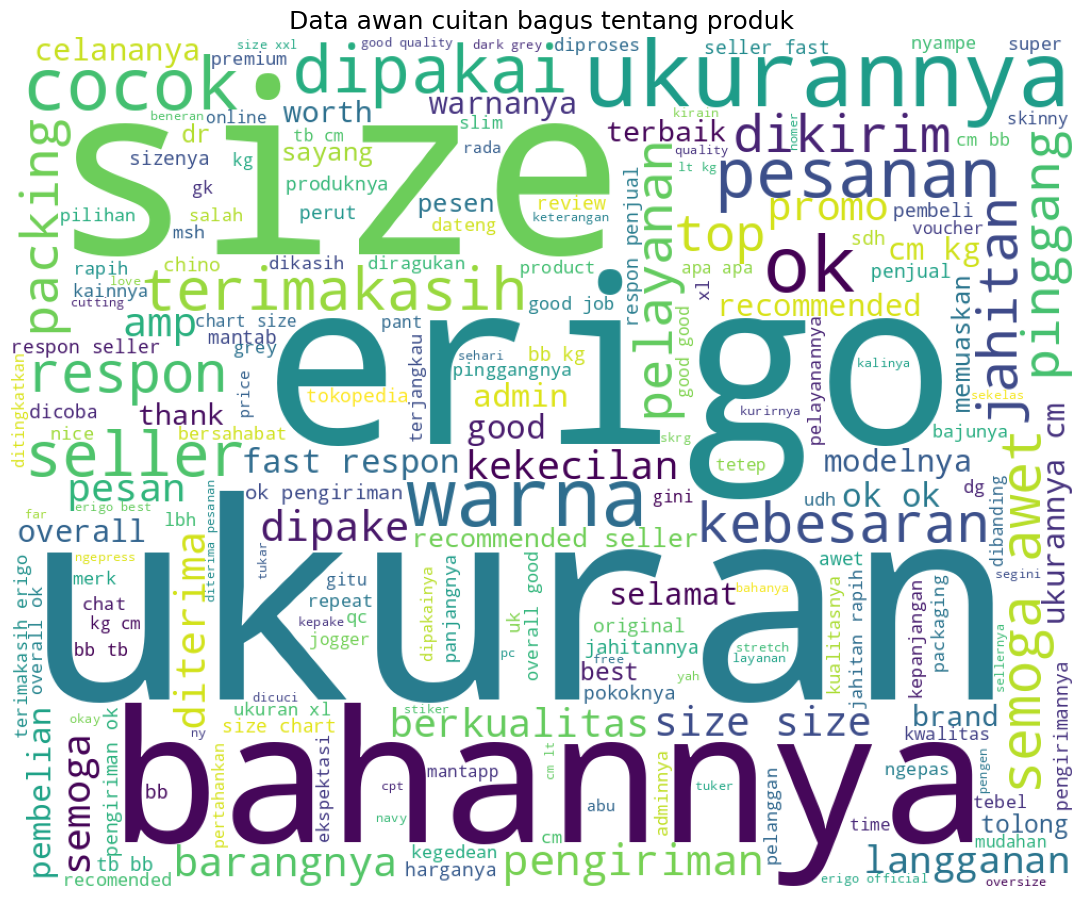

In [91]:
#Cuitan positif
positif = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitanp['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        positif += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=800, background_color='white', min_font_size=10).generate(positif)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(11, 11))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan bagus tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

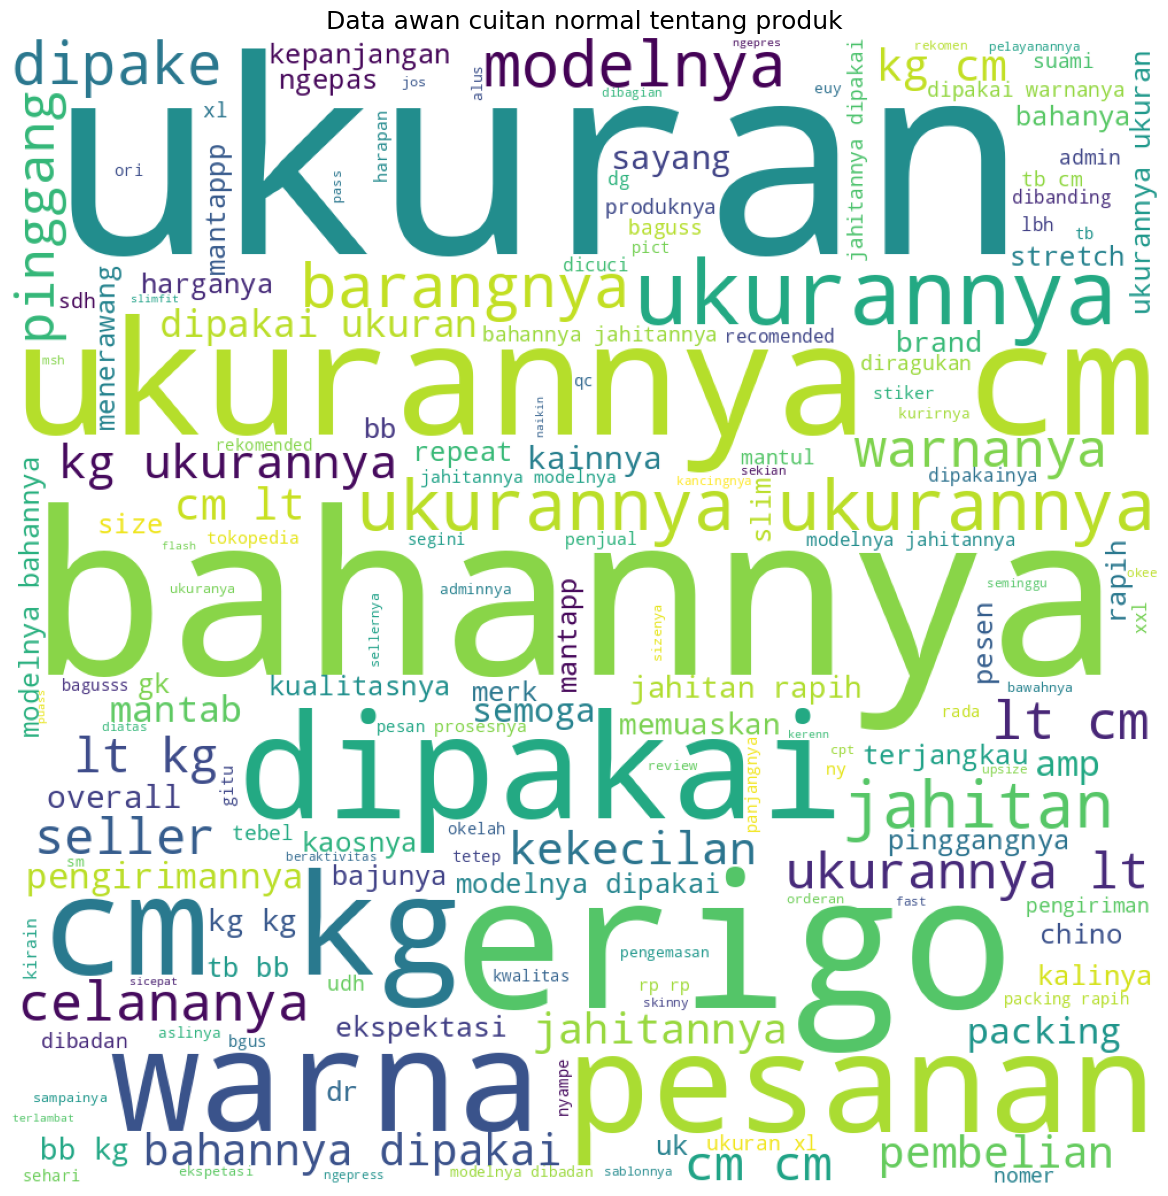

In [92]:
#Cuitan netral
normal = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitanz['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        normal += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=1000, background_color='white', min_font_size=10).generate(normal)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(12, 12))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan normal tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

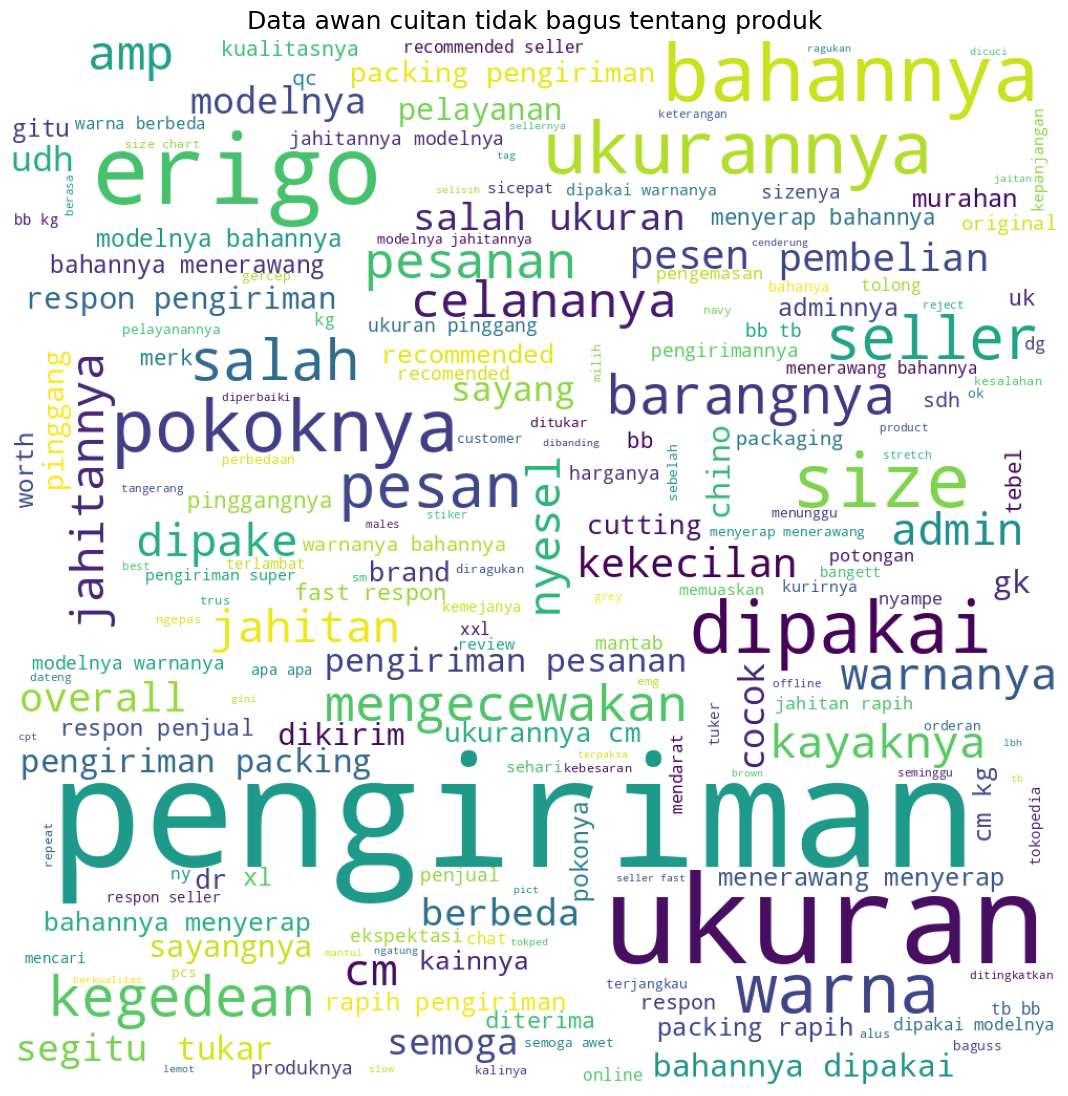

In [93]:
#Cuitan negatif
negatif = ''

# Iterasi melalui setiap tweet dalam kolom stopword di cuitann.
for tweet in cuitann['stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        negatif += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=1000, height=1000, background_color='white', min_font_size=10).generate(negatif)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(11, 11))

# Menetapkan judul untuk word cloud.
ax.set_title('Data awan cuitan tidak bagus tentang produk', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

#### Grafik Batang

In [94]:
#cek kolom
dfkopitungk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10038 entries, 0 to 12440
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pesan            10038 non-null  object 
 1   Nilai            10038 non-null  float64
 2   Label            10038 non-null  object 
 3   bersih           10038 non-null  object 
 4   kecil            10038 non-null  object 
 5   sopan            10038 non-null  object 
 6   token            10038 non-null  object 
 7   stopword         10038 non-null  object 
 8   final            10038 non-null  object 
 9   nilai_polaritas  10038 non-null  float64
 10  polaritas        10038 non-null  object 
dtypes: float64(2), object(9)
memory usage: 941.1+ KB


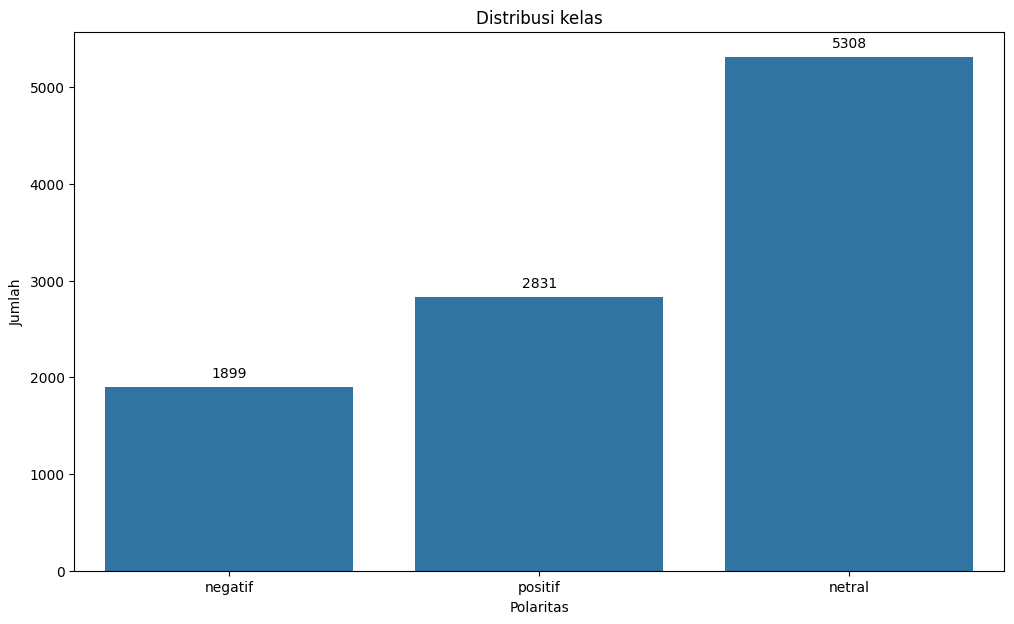

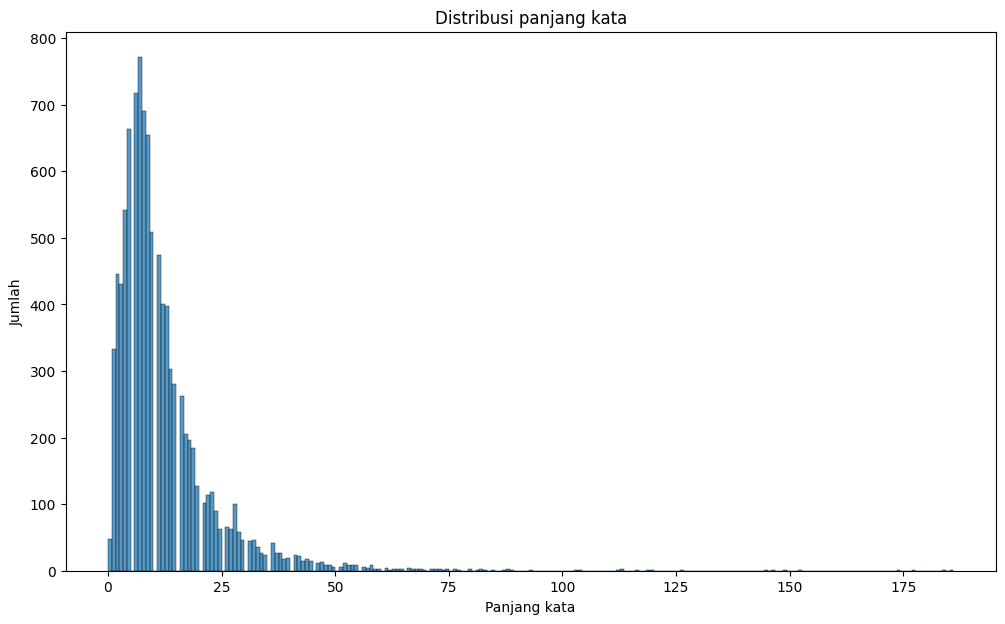

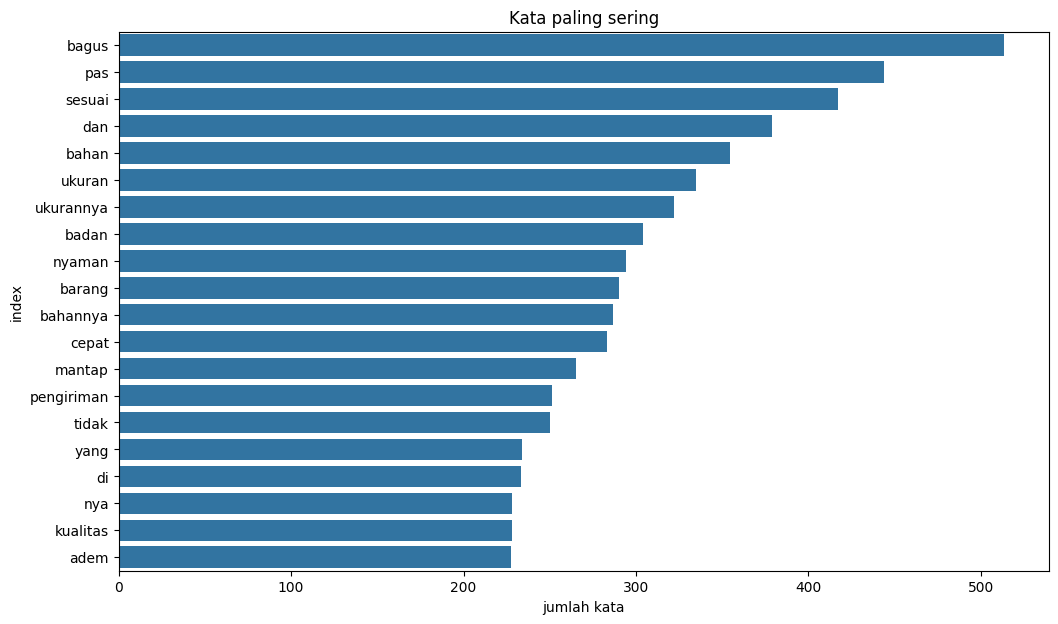

In [95]:
#Grafik batang
# Set the figure size
plt.figure(figsize=(12, 7))

# Check class distribution
class_dist_plot = sns.countplot(x='polaritas', data=dfkopitungk)
plt.title('Distribusi kelas')
plt.xlabel('Polaritas')
plt.ylabel('Jumlah')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Set the figure size
plt.figure(figsize=(12, 7))

# Visualize text length distribution
dfkopitungk['panjang_kata'] = dfkopitungk['final'].apply(lambda x: len(x.split()))
sns.histplot(dfkopitungk['panjang_kata'])
plt.title('Distribusi panjang kata')
plt.xlabel('Panjang kata')
plt.ylabel('Jumlah')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 7))

# Inspeksi kata paling sering
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dfkopitungk['final'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah kata')
tfidf_df = tfidf_df.sort_values('jumlah kata', ascending=False).head(20)
sns.barplot(x='jumlah kata', y='index', data=tfidf_df)
plt.title('Kata paling sering')
plt.show()

#Eksekusi model
Prosedur yang digunakan
1. Teknik RFC ('Random Forest Classifier') dengan vektorisasi TFID
2. Teknik Support Vector dengan vektorisasi 'Fast Text'
3. Teknik Regresi Logistik dengan vektorisasi

## Persiapan model

In [99]:
#Pemisahan data
Xst = dfkopitungk['final'].copy() #cuitan
yst = dfkopitungk['polaritas'].copy() #pelabelan
#cek bentuk kolom polaritas
tippol = yst.unique().copy()
print(tippol)

['negatif' 'positif' 'netral']


In [127]:
#pelabelan untuk anaisis


In [97]:
#pembuatan df model
dfmodmen = pd.DataFrame({'Cuitan': Xst, 'Pelabelan': yst})
dfmodmen.head(7)

,Cuitan,Pelabelan
0,mantapo bangett baguss bahannya lembut nyaman dipake lanjut bakal order lagi buay suamii kuu okee gasskeun ahay,negatif
1,pesanan selamat sampai tujuan keren tshirt nya cuttingan overzise tb bb pakai size xxl keren juga cuy erigo top terimakasih semoga awet,positif
2,kualitas produk bagus jahitannya rapi nyaman dipakai warnanya mantap modelnya keren bahannya lembut bahannya adem ukuran sesuai bahan menyerap keringat tidak menerawang biarkan bintang yang berbicara,negatif
3,bagus banget ukuran pas bahan tebal tapi adem sablon timbul cutting dan jahitan rapiiih,negatif
4,pengiriman cepetseller gercep alias gerak cepatselalu langganan produknya di jamin puas sudah langganansudah langgan selalu di erigo,negatif
5,sesuai pesanan meskipun pengirimannya lama bahannya adem meskipun agak tebal thank you erigo,positif
6,response seller mantul packing dan pengiriman juga kilat selagi harga nya lagi diskon makanya kita beli untuk kualitas sih ok terima kasih yah,negatif


### Vektorisasi untuk masing-masing data

In [101]:
#pelabelan dengan vektorisasi
tfidfv = TfidfVectorizer(max_features=450, min_df=17, max_df=0.8)
X_tfidf = tfidfv.fit_transform(Xst)
#pembuatan barisan [array]
Xtdifar = X_tfidf.toarray()
#pembuatan kolom
Xcolumns = tfidfv.get_feature_names_out()

In [ ]:
#vektorisasi dengan 'Fast Text' di SVM
lenco = LabelEncoder()
ysten = lenco.fit_transform(yst)

In [ ]:
#eksekusi dengan fast text: Tokenisasi
tokenisasi = [tweet.split() for tweet in Xst]

# Train FastText model
fasttext_model = FastText(sentences=tokenisasi, vector_size=101, window=3, min_count=1, workers=4)

# Create feature vectors for each tweet
X_fst = []
for tweet in tokenisasi:
    # Get vectors for words present in the model's vocabulary
    word_vectors = [fasttext_model.wv[word] for word in tweet if word in fasttext_model.wv]

    # Perhitungan jika ada vektor atau nilai nol
    if word_vectors:
        vector = np.mean(word_vectors, axis=0)  # Calculate average of word vectors
    else:
        vector = np.zeros(fasttext_model.vector_size)  # Create zero vector

    X_fst.append(vector)

X_fasttext = np.array(X_fst)

### Persiapan pelatihan

In [102]:
#pemisahan data menjadi sampel dan latihan di RFC
X_train, X_test, y_train, y_test = train_test_split(Xtdifar, yst, test_size=0.25, random_state=40, stratify=yst)

In [ ]:
#penyatuan kembail ke df untuk SVM
X_trains, X_tests, y_trains, y_tests = train_test_split(X_fasttext, ysten, test_size=0.251, random_state=40, stratify=ysten)

Tanda **'S'** menyatakann SVM

In [137]:
#pemakaian latihan & tes untuk regresi logistik
X_trainreg, X_testreg, y_trainreg, y_testreg = train_test_split(Xst, yenco, test_size=0.245, random_state=40, stratify=yst)

In [138]:
#pelatihan kata untuk pra pemrosesan di regresi
train_sentences = [text.split() for text in X_trainreg]
test_sentences = [text.split() for text in X_testreg]

In [139]:
#persiapan data latihan untuk Regresi Logistik melalui Word2vec
w2vmod = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4, compute_loss=True)

In [148]:
#vektorisasi dengan word2vec
def sentence_to_vector(sentence):
    words = sentence.split()
    word_vectors = [w2vmod.wv[word] for word in words if word in w2vmod.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2vmod.vector_size)
#ke persiapan

In [157]:
#eksekusi konversi
X_train_vec = np.array([sentence_to_vector(sentence) for sentence in X_trainreg])
X_test_vec = np.array([sentence_to_vector(sentence) for sentence in X_testreg])

### Pemasangan Berat sampel

In [103]:
#Modifikais ADASYN
adsyn = ADASYN(random_state=40)
X_train2, y_train2 = adsyn.fit_resample(X_train, y_train)

In [104]:
#pemasangan berat sampel
brtsampllat = csw(class_weight='balanced', y=y_train) #menyeimbangkan berat di latihan
brtsampllatads = csw(class_weight='balanced', y=y_train2) #menyeimbangkan berat di pengujian pasca ADASYN
#ke tes

In [105]:
#di sumbu tes
brtsamptes = csw(class_weight='balanced', y=y_test) #menyeimbangkan berat di pengujian

In [ ]:
#berat sampel di SVM
brtsampllatsv = csw(class_weight='balanced', y=y_trains) #menyeimbangkan berat di latihan untuk SVM
brtsamptessv = csw(class_weight='balanced', y=y_tests) #menyeimbangkan berat di pengujian untuk SVM

In [140]:
#Penerapan berat sampel di regresi logistik
brtsamplatreg = csw(class_weight='balanced', y=y_trainreg) #menyeimbangkan berat di latihan untuk Regresi Logistik
brtsamptestreg = csw(class_weight='balanced', y=y_testreg) #menyeimbangkan berat di pengujian

## Deklarasi Kamus Berat

In [106]:
#pemasangan berat data melalui Persiapan kamus berat sampel
klsbrt = np.unique(y_train) #kelas berat di RFC normal
dictbrt = dict(zip(klsbrt, brtsampllat)) #dideklarasikan sebagai kampus [normal]

In [107]:
#Kondisi ADASYN
klsbrts = np.unique(y_train2) #kelas berat di RFC pasca ADASYN
dictbrta = dict(zip(klsbrts, brtsampllatads)) #dideklarasikan sebagai kampus [pasca ADASYN]

In [ ]:
#Kondisi SVM
klsbrtsv = np.unique(y_trains) #kelas berat di SVM normal
dictbrtsv = dict(zip(klsbrtsv, brtsampllatsv)) #dideklarasikan sebagai kampus [normal]

In [143]:
#Kondisi Regresi Logistik
klsbrtre = np.unique(y_trainreg.toarray()) #kelas berat di regresi logistik normal
dictbrtre = dict(zip(klsbrtre, brtsamplatreg)) #dideklarasikan sebagai kampus [normal]

In [ ]:
#penyeimbangan berat di RFC


In [ ]:
#penyeimbangan berat di SVM
brtsimb = {label: (sum(y_trains) / count) for label, count in zip(klsbrtsv, brtsampllatsv)} #seimbangkan berat di SVM
#ubah ke bentuk barisan
brsbrt = np.array([brtsimb[label] for label in y_trains]) #jadi baris
print(brsbrt)

### Eksekusi dalam kondisi normal

In [119]:
#eksekusi normal
randford = rfclasifi(n_estimators=110,max_depth=24,ccp_alpha=5.45e-7,min_samples_split=4,min_samples_leaf=4,
    max_leaf_nodes=26,class_weight=dictbrt,random_state=40,warm_start = True, oob_score=True, verbose=1) #normal
#ke eksekusi tanpa fungsi

In [109]:
#eksekusi dengan ADASYN
randfordada = rfclasifi(n_estimators=108,max_depth=24,ccp_alpha=7.75e-5,max_leaf_nodes=20,min_samples_split=7,min_samples_leaf=7,
                        class_weight=dictbrta,random_state=39,warm_start = True, oob_score=True) #pakai ADASYN
#ke eksekusi fungsi

In [120]:
#implementasi 'validasi silang'
scores = cross_val_score(randford, X_train, y_train, cv=7)
#pembulatan
rounded = np.round(scores,3)
#percetakan
print(rounded)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


[0.827 0.824 0.816 0.825 0.831 0.805 0.813]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [121]:
#eksekusi tanpa inspeksi
randford.fit(X_train, y_train, sample_weight=brtsampllat)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


RandomForestClassifier(ccp_alpha=5.45e-07,
                       class_weight={'negatif': 0.6303273884283681,
                                     'netral': 0.6303273884283681,
                                     'positif': 1.1819751923378867},
                       max_depth=24, max_leaf_nodes=26, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=110, oob_score=True,
                       random_state=40, verbose=1, warm_start=True)

In [122]:
#Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = randford.predict(X_train)
y_pred_test_rf = randford.predict(X_test)

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train, sample_weight=brtsampllat)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test, sample_weight=brtsamptes)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [123]:
# Menghitung precision, recall, dan F1 score untuk data uji di kondisi normal
precision_test_rf = precision_score(y_test, y_pred_test_rf, average='weighted', zero_division =0, sample_weight = brtsamptes)
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='weighted', zero_division =0, sample_weight = brtsamptes)
f1_test_rf = f1_score(y_test, y_pred_test_rf, average='weighted', zero_division =0, sample_weight = brtsamptes)

# Pembulatan nilai untuk kemudahan
rounded_accuracy_train = round(accuracy_train_rf, 3)
rounded_accuracy_test = round(accuracy_test_rf, 3)
rounded_precision = round(precision_test_rf, 3)
rounded_recall = round(recall_test_rf, 3)
rounded_f1 = round(f1_test_rf, 3)

# Menampilkan hasil evaluasi
print('Nilai Akurasi di latihan dengan RFC:', rounded_accuracy_train)
print('Nilai Akurasi di tes dengan RFC:', rounded_accuracy_test)
print('Nilai Presisi di RFC:', rounded_precision)
print('Nilai panggilan balik di RFC:', rounded_recall)
print('Inspeksi nilai F1 di RFC:', rounded_f1)

Nilai Akurasi di latihan dengan RFC: 0.712
Nilai Akurasi di tes dengan RFC: 0.685
Nilai Presisi di RFC: 0.777
Nilai panggilan balik di RFC: 0.685
Inspeksi nilai F1 di RFC: 0.686


### Modifikasi 'Grid search'

In [ ]:
#inisasi RCF modifikasi
randfordmod = rfclasifi(random_state=40, oob_score=True)

In [ ]:
#deklarasi dengan grid
param_grid = {'n_estimators': [108, 152],'max_features': ['auto', 'sqrt', 2],'max_depth': [3, 6, 9, 12],'min_samples_split': [2, 4, 5, 8, 10],'min_samples_leaf': [1, 2, 4, 5],"criterion": ["gini", "entropy"],"ccp_alpha": [4.5e-4, 5.5e-4, 6.5e-4] }

In [ ]:
#pelacakan grid
grid_search = GridSearchCV(estimator=rfclasifi(class_weight= dictbrt,warm_start=True), param_grid=param_grid,
                           scoring='accuracy', cv=6, verbose=1, return_train_score=True)

In [ ]:
#Eksekusi parameter
best_params = grid_search.param_grid
print("Parameter Terbaik:", best_params)
#penyesuaian
grid_search.fit(X_train, y_train)

In [ ]:
#latihan dengan model terbaik
best_rf_model = grid_search.best_estimator

In [ ]:
#eksekusi dengan Grid
y_pred_train_rf = best_rf_model.predict(X_train)
y_pred_test_rf = best_rf_model.predict(X_test)

In [ ]:
#evaluasi dengan modifikasi
accuracy_train_rf = accuracy_score(y_train2, y_pred_train_rf, sample_weight=brtsampllat)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf, sample_weight=brtsamptes)

precision_test_rf = precision_score(y_test, y_pred_test_rf, average='weighted', zero_division=0, sample_weight=brtsamptes)
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='weighted', zero_division=0, sample_weight=brtsamptes)
f1_test_rf = f1_score(y_test, y_pred_test_rf, average='weighted', zero_division=0, sample_weight=brtsamptes)

# Step 9: Round and print results
rounded_accuracy_train = round(accuracy_train_rf * 100, 2)
rounded_accuracy_test = round(accuracy_test_rf * 100, 2)
rounded_precision = round(precision_test_rf * 100, 2)
rounded_recall = round(recall_test_rf * 100, 2)
rounded_f1 = round(f1_test_rf * 100, 2)

print('Akurasi melalui teknik RFC di fasa latihan:', rounded_accuracy_train)
print('Akurasi melalui teknik RFC di fasa pengujian:', rounded_accuracy_test)
print('Nilai presisi di RFC:', rounded_precision)
print('Nilai pemangilan ualng di RFC:', rounded_recall)
print('F1 Score with RFC:', rounded_f1)

## Pendukungan Vektor

In [ ]:
#tahap awal
dtrain = xgb.DMatrix(X_trains, label=y_trains, weight=brsbrt)
dtest = xgb.DMatrix(X_tests)
pnjlat = len(np.unique(y_trains)) #panjang latihan
#parameter
paramet  = {
    'objective': 'multi:softmax',  # Spesifikasikan
    'num_class': pnjlat,
    'max_depth': 6,'min_child_weight': 2,'eta': 0.055,
    'subsample': 0.805,
    'colsample_bytree': 0.805,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'eval_metric': 'mlogloss',
    'n_estimators': 120,
    'verbosity': 1,
    'brtnorm' : brtsimb
}

In [ ]:
#latihan dataset dengan XGB
bst = xgb.train(paramet, dtrain, num_boost_round=250)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:38:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "brtnorm", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
#hasil terbaik
y_pred_train_xgb = bst.predict(dtrain)
y_pred_test_xgb = bst.predict(dtest)
#cetak hasil untuk Evaluasi dan Latihan
accuracy_train_xgb = accuracy_score(y_trains, y_pred_train_xgb)
accuracy_test_xgb = accuracy_score(y_tests, y_pred_test_xgb)

precision_test_xgb = precision_score(y_tests, y_pred_test_xgb, average='weighted', zero_division=0)
recall_test_xgb = recall_score(y_tests, y_pred_test_xgb, average='weighted', zero_division=0)
f1_test_xgb = f1_score(y_tests, y_pred_test_xgb, average='weighted', zero_division=0)

# Display results
print(f'Akurasi Latihan : {accuracy_train_xgb:.3f}')
print(f'Akurasi Tes: {accuracy_test_xgb:.3f}')
print(f'Presisi : {precision_test_xgb:.3f}')
print(f'Pangilan ulang: {recall_test_xgb:.3f}')
print(f'Nilai F1: {f1_test_xgb:.3f}')

Akurasi Latihan : 0.939
Akurasi Tes: 0.625
Presisi : 0.634
Pangilan ulang: 0.625
Nilai F1: 0.610


## Tahap Native Bayes

In [158]:
#tahap 1


In [ ]:
#tahap lanjutan : pemadatan


In [ ]:
#Eksekusi untuk menentukan hasil


In [ ]:
#inspeksi hasil dan pembulatan


In [ ]:
#inspeksi hasil


# Pengujian sentimen

In [ ]:
#persiapan kode


In [ ]:
#Tahap 'pra-pemrosesan'
